# Deep Learning Starter

In this kernel, I directly feed the data into a **Recurrent Neural Network**. For fancyness, I added an **Attention Mechanism**.

Because of reproductibility issues, results are very unstable. The solution is to move to PyTorch but I wanted to produce something quickly.

In [54]:
import tensorflow

In [55]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import *
from sklearn.model_selection import *

import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

### Load Data

In [56]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
sub = pd.read_csv("sample_submission.csv")

In [57]:

# def feature_normalize(dataset):
#     mu = np.mean(dataset, axis=0)
#     sigma = np.std(dataset, axis=0)
#     return (dataset - mu) / sigma

In [58]:
# def feat_norm(dataset):
#     minVal = min(dataset[:])
#     maxVal = max(dataset[:])
#     return (dataset - minVal) / (maxVal - minVal)

In [59]:
# feat_norm(data)

In [60]:
# # del data['row_id']
# del data['measurement_number']
# del data['series_id']

In [61]:
# nu = np.mean(data, axis=0)
# nu

In [62]:
# sig = np.std(data, axis=0)
# sig

In [63]:
# feature_normalize(data).head()

In [64]:
# data/10

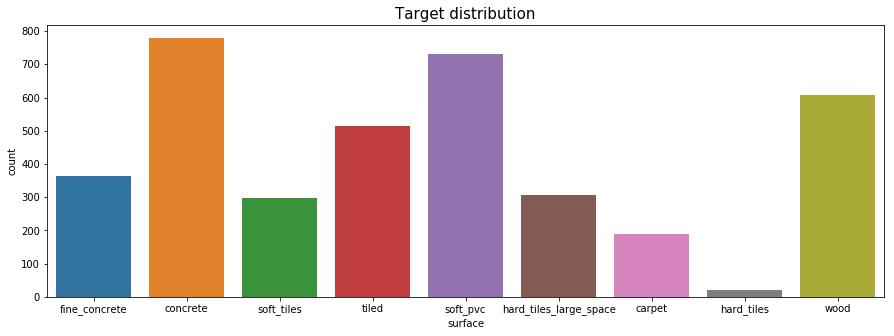

In [65]:
plt.figure(figsize=(15, 5))
sns.countplot(y_train['surface'])
plt.title('Target distribution', size=15)
plt.show()

## Make Data for the Network

### Input

In [66]:
X_train.drop(['row_id', "series_id", "measurement_number"], axis=1, inplace=True)
X_train = X_train.values.reshape((3810, 128, 10))

In [21]:
X_test.drop(['row_id', "series_id", "measurement_number"], axis=1, inplace=True)
X_test = X_test.values.reshape((3816, 128, 10))

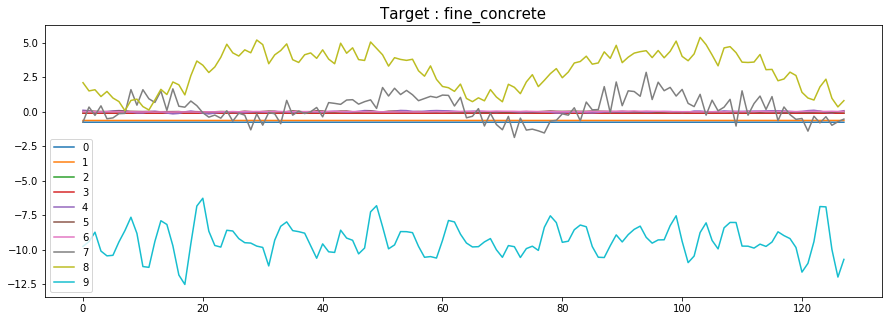

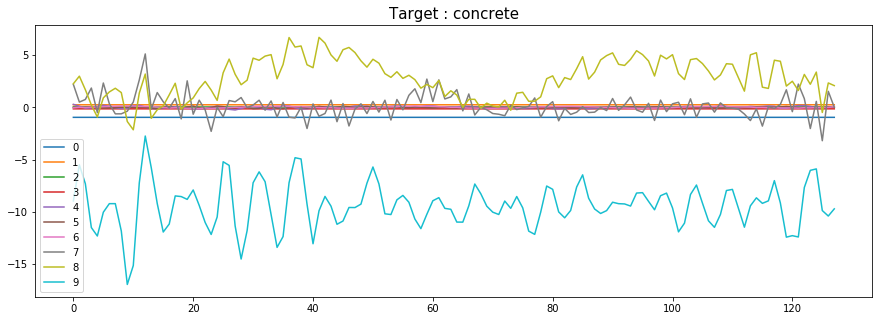

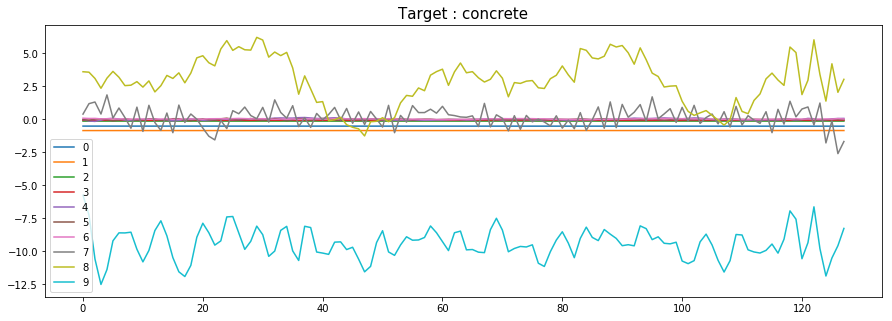

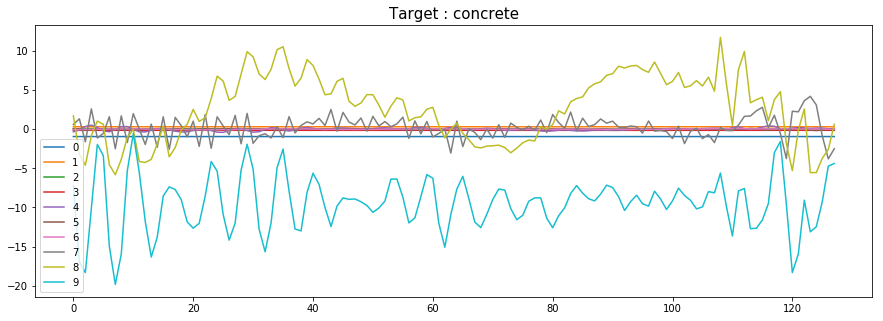

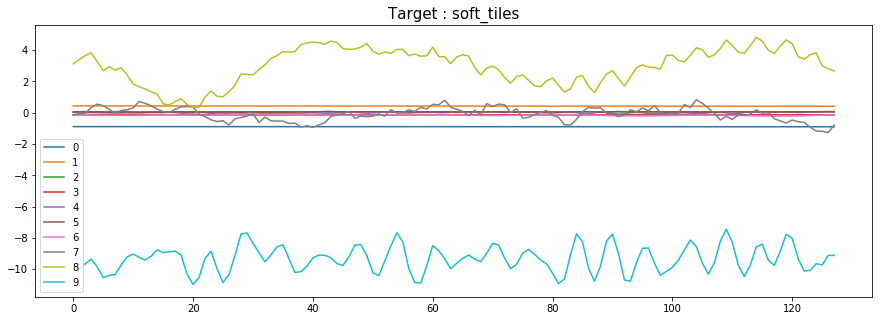

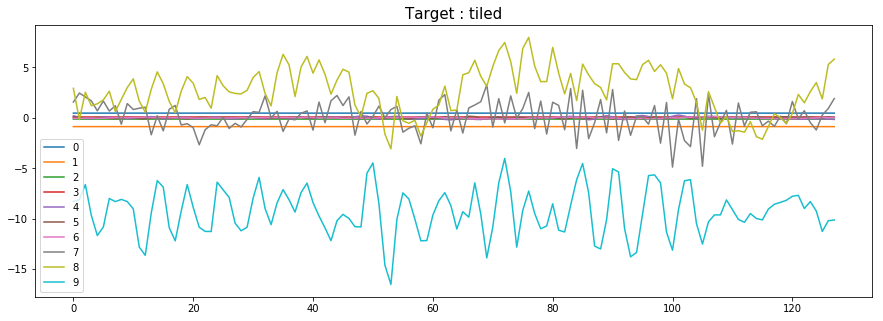

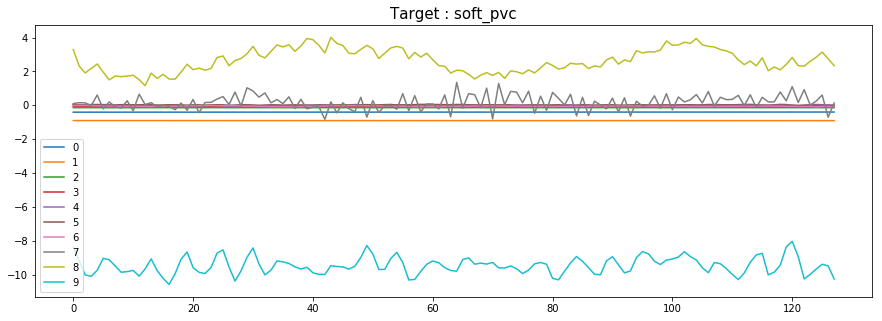

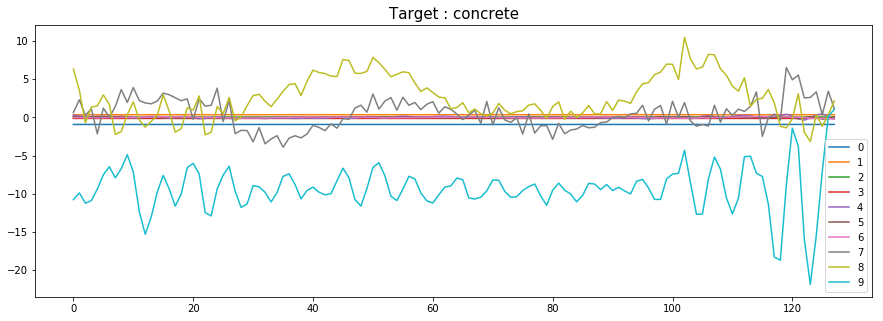

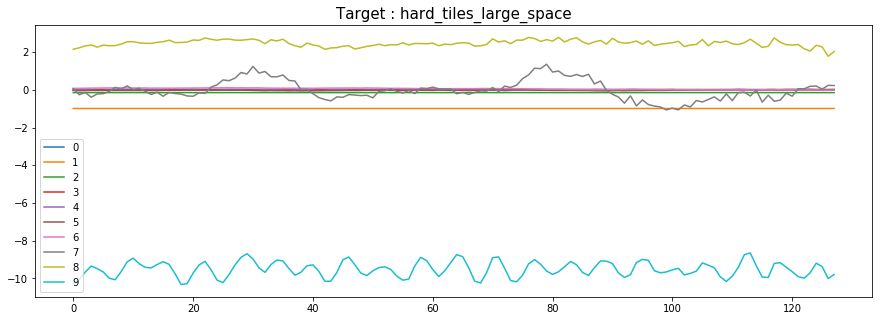

In [22]:
for j in range(9):
    plt.figure(figsize=(15, 5))
    plt.title("Target : " + y_train['surface'][j], size=15)
    for i in range(10):
        plt.plot(X_train[j, :, i], label=i)
    plt.legend()
    plt.show()

### Ouput

We encode our targets

In [23]:
encode_dic = {'fine_concrete': 0, 
              'concrete': 1, 
              'soft_tiles': 2, 
              'tiled': 3, 
              'soft_pvc': 4,
              'hard_tiles_large_space': 5, 
              'carpet': 6, 
              'hard_tiles': 7, 
              'wood': 8}

In [24]:
decode_dic = {0: 'fine_concrete',
              1: 'concrete',
              2: 'soft_tiles',
              3: 'tiled',
              4: 'soft_pvc',
              5: 'hard_tiles_large_space',
              6: 'carpet',
              7: 'hard_tiles',
              8: 'wood'}

In [25]:
y_train = y_train['surface'].map(encode_dic).astype(int)

## Modeling

###  Attention Layer
Because that's fancy

In [26]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],), initializer=self.init, name='{}_W'.format(self.name), regularizer=self.W_regularizer, constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None: a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

### Model

In [38]:
def make_model():
    inp = Input(shape=(128, 10))
    x = Bidirectional(CuDNNLSTM(32, return_sequences=True))(inp)
    x = Attention(128)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(9, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### $k$-Folds

In [52]:
def k_folds(X, y, X_test, k=5):
    folds = list(StratifiedKFold(n_splits=k).split(X, y))
    y_test = np.zeros((X_test.shape[0], 9))
    y_oof = np.zeros((X.shape[0]))
    
    for i, (train_idx, val_idx) in  enumerate(folds):
        print(f'Fold {i+1}')
        model = make_model()
        model.fit(X[train_idx], y[train_idx], batch_size=128, epochs=100, 
                  validation_data=[validation_part_df, y[val_idx]], verbose=0)
        
        pred_val = np.argmax(model.predict(X[val_idx]), axis=1)
        score = accuracy_score(pred_val, y[val_idx])
        y_oof[val_idx] = pred_val
        
        print(f'Scored {score:.3f} on validation data')
        
        y_test += model.predict(X_test)
        
    return y_oof, y_test                                                                          

In [53]:
y_oof, y_test = k_folds(train_part_df, y_train, X_test, k=5)

ValueError: Found input variables with inconsistent numbers of samples: [3303, 3810]

In [40]:
print(f'Local CV is {accuracy_score(y_oof, y_train): .4f}')

Local CV is  0.6323


### Confusion Matrix

In [32]:
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

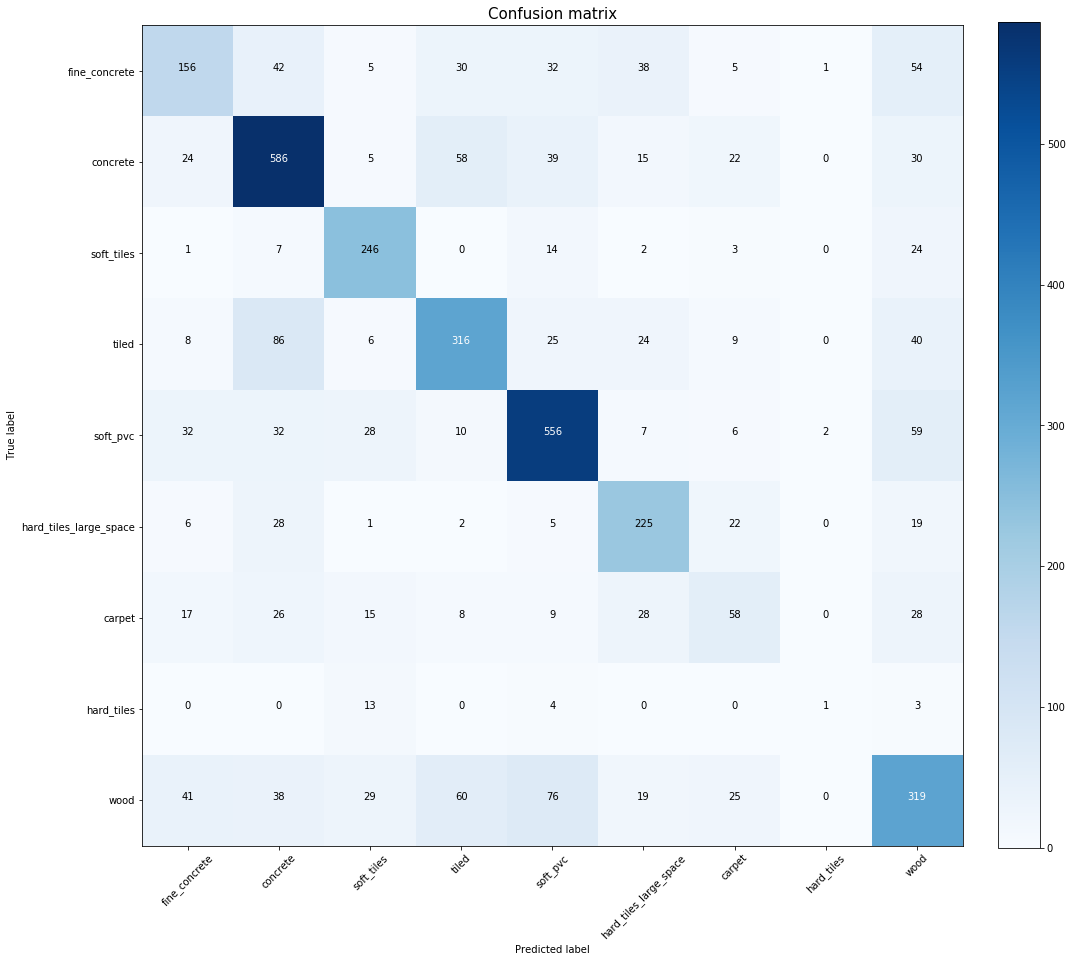

In [33]:
plot_confusion_matrix(y_train, y_oof, encode_dic.keys())

### Submission

In [41]:
y_test = np.argmax(y_test, axis=1)

In [47]:
sub['surface'] = y_test
sub['surface'] = sub['surface'].map(decode_dic)
sub

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,wood
4,4,soft_pvc
5,5,concrete
6,6,fine_concrete
7,7,concrete
8,8,wood
9,9,wood


In [43]:
sub.to_csv('submission4.csv', index=False)

### Thanks for reading ! 
##### Please leave an upvote, it is always appreciated!

In [48]:
train_part_df

,series_id,lx,ly,lz,ax,ay,az,ox,oy,oz,ow,group_id,surface
705,705,"[1.0599, 0.67683, 0.05145, 1.1831, -0.4169, 0....","[4.269, 3.9465, 3.0171, 4.2538, 4.5167, 4.9294...","[-9.311, -9.5978, -10.694, -10.162, -8.958, -8...","[-0.06254900000000001, -0.091793, -0.069603, -...","[-0.0333, -0.047261000000000004, -0.063349, -0...","[0.090918, 0.10492, 0.094859, 0.10922, 0.11525...","[-0.049204000000000005, -0.049295, -0.049424, ...","[-0.98734, -0.98731, -0.98729, -0.98729, -0.98...","[-0.15075999999999998, -0.15093, -0.1510099999...","[0.0015834000000000002, 0.0015653, 0.001500799...",35,fine_concrete
1053,1053,"[4.1902, 1.4065, 2.5473, 1.1989, 2.5418, 3.691...","[4.6003, 0.39036, 4.3671, 5.5233, 2.7866, 3.92...","[-11.3, -15.449000000000002, -11.339, -8.8356,...","[-0.24934, -0.081845, 0.09301799999999999, -0....","[-0.028916000000000004, 0.036182, -0.049010000...","[-0.15222, -0.1522, -0.11391, -0.037259, -0.05...","[-0.9481700000000001, -0.9482, -0.948270000000...","[0.28009, 0.2799, 0.27981, 0.27979, 0.27973000...","[0.033667, 0.033681, 0.033727, 0.033882, 0.034...","[-0.14628, -0.14637999999999998, -0.1461400000...",10,wood
1873,1873,"[0.68261, -1.6629, -0.15744, -1.3043, -0.89992...","[5.2693, 5.8008, 5.5426, 5.1001, 4.0696, 4.782...","[-10.92, -6.0997, -6.2391, -8.2744, -11.29, -1...","[0.053720000000000004, 0.015774, -0.10692, -0....","[0.051345, -0.014693000000000001, -0.077154, 0...","[0.021238999999999997, 0.029532999999999997, 0...","[-0.9884700000000001, -0.98846, -0.98844, -0.9...","[0.016291, 0.016388999999999997, 0.01641100000...","[-0.0041356000000000006, -0.0041724, -0.004075...","[-0.15045999999999998, -0.15056, -0.1506900000...",66,tiled
1974,1974,"[-0.31267, -1.3485, -2.6824, 1.3265, -1.9221, ...","[1.2496, -1.2961, -0.017625, 3.6423, 2.1984, 1...","[-11.242, -14.878, -11.214, -5.3645, -3.5856, ...","[-0.12977, 0.14404, 0.38458000000000003, 0.315...","[0.049152999999999995, 0.015222, -0.1418299999...","[0.015652000000000003, 0.12244000000000001, 0....","[0.62992, 0.62995, 0.62984, 0.62967, 0.62948, ...","[-0.767, -0.76708, -0.76726, -0.76745, -0.7676...","[-0.088433, -0.087865, -0.08759199999999999, -...","[0.084277, 0.08380900000000001, 0.083386, 0.08...",69,soft_pvc
860,860,"[1.7946, 0.809, 1.1919, 1.5183, 0.56587, 1.919...","[1.9157, 2.4724, 3.9572, 4.2201, 2.226, 1.9968...","[-11.386, -11.197000000000001, -8.9652, -8.183...","[-0.0457, 0.01934, 0.037022, -0.03017799999999...","[-0.027859, -0.0027344, 0.020118, 0.011766, -0...","[0.042166, 0.068986, 0.027174, 0.0612799999999...","[0.8311299999999999, 0.8311, 0.83109, 0.83105,...","[-0.53561, -0.5357, -0.53572, -0.53578, -0.535...","[-0.075421, -0.075347, -0.075297, -0.075295, -...","[0.12907000000000002, 0.12892, 0.1289, 0.12894...",26,soft_pvc
2569,2569,"[-2.883, 3.8728, 3.1998, 2.1415, 2.9223, -2.15...","[0.3933, -0.60019, 2.6398, 0.47894, -0.9031600...","[-8.3841, -11.962, -8.8203, -9.4529, -9.7098, ...","[-0.026518, -0.0030413, 0.035, 0.0491949999999...","[0.27466999999999997, 0.31517, 0.35509, 0.1613...","[-0.80898, -0.8422, -0.8135899999999999, -0.82...","[0.35864, 0.35762, 0.35662, 0.3557099999999999...","[0.92156, 0.92195, 0.9223399999999999, 0.92271...","[0.1412, 0.14129, 0.14135999999999999, 0.14122...","[0.046567000000000004, 0.046354, 0.046073, 0.0...",40,hard_tiles_large_space
1699,1699,"[-0.15307, -0.15471, -0.2621, -0.2749, -0.3384...","[3.0777, 3.1241, 3.2048, 3.3756, 3.3123, 3.191...","[-9.3637, -9.2885, -9.2131, -9.2526, -9.4687, ...","[0.007149600000000001, 0.014293, 0.0038341, -0...","[0.11002, 0.10910999999999998, 0.1122599999999...","[-0.36507, -0.36521, -0.36646, -0.36362, -0.36...","[-0.23141, -0.23095, -0.23049, -0.23003, -0.22...","[-0.961, -0.96111, -0.9612299999999999, -0.961...","[-0.1487, -0.1487, -0.14872, -0.14874, -0.1487...","[-0.028491000000000002, -0.028423, -0.028355, ...",16,hard_tiles_large_space
966,966,"[0.20622, 0.8747, 0.66365, 0.8518, -0.036788, ...","[3.615, 3.9160000000000004, 3.2616, 3.0432, 4....","[-8.5352, -8.

In [49]:
validation_part_df

,series_id,lx,ly,lz,ax,ay,az,ox,oy,oz,ow,group_id,surface
3637,3637,"[-0.47357, 0.3822, 0.17104, 0.48782, 0.77603, ...","[2.9038, 3.4596, 3.6348, 3.1859, 2.9975, 3.123...","[-10.807, -9.9465, -9.0714, -9.0965, -9.3947, ...","[-0.005517899999999999, 0.013743, -0.006453699...","[-0.15749000000000002, -0.15045, -0.13111, -0....","[0.53174, 0.5392100000000001, 0.55282, 0.56189...","[0.8795299999999999, 0.87923, 0.8789, 0.878570...","[-0.45227, -0.45285, -0.45348, -0.454119999999...","[-0.06037000000000001, -0.060459000000000006, ...","[0.13507, 0.13501, 0.13499, 0.13498, 0.13497, ...",45,wood
154,154,"[-0.69266, -0.013881000000000001, 0.059675, -0...","[4.7659, 4.2148, 4.6618, 3.8228, 3.923, 3.8385...","[-8.4976, -10.015, -10.377, -10.248, -9.1375, ...","[-0.034723000000000004, -0.038463, -0.00306369...","[-0.036311, -0.07671900000000001, -0.107459999...","[0.30601999999999996, 0.30006, 0.3219800000000...","[0.91835, 0.91822, 0.91807, 0.9179299999999999...","[-0.3668, -0.3671, -0.36749, -0.36787, -0.3682...","[-0.051467, -0.051526999999999996, -0.051596, ...","[0.13946, 0.13946, 0.13943, 0.13932, 0.1392, 0...",6,soft_pvc
211,211,"[-1.1162, -1.8038, -0.29091, -2.0577, 0.46388,...","[4.2466, 4.9216, 3.9884, 3.2746, 3.6459, 3.187...","[-8.8836, -8.6785, -10.055, -10.752, -9.3447, ...","[0.036000000000000004, -0.0060648, -0.0024408,...","[0.039722, 0.06356200000000001, 0.093333, 0.04...","[-0.11141, -0.14773, -0.12834, -0.134, -0.1272...","[0.44435, 0.4442, 0.44404, 0.44388999999999995...","[0.88284, 0.88292, 0.883, 0.8830899999999999, ...","[0.13942000000000002, 0.1394, 0.13945, 0.13940...","[0.060842999999999994, 0.060846000000000004, 0...",19,soft_pvc
1443,1443,"[1.1072, -1.3201, 1.7692, 0.74224, 0.43578, 1....","[4.1915, 2.3424, 2.6167, 0.63007, 1.5982, 3.25...","[-10.389000000000001, -9.112, -9.3804, -10.862...","[0.11375, 0.058563, 0.036941, 0.061898, 0.0771...","[0.023216, -0.033089999999999994, -0.1058, -0....","[0.14399, 0.16304000000000002, 0.14001, 0.1464...","[-0.19197999999999998, -0.19215, -0.19234, -0....","[-0.9698899999999999, -0.96985, -0.96982000000...","[-0.14839000000000002, -0.14841, -0.14834, -0....","[-0.020942, -0.020944, -0.021037, -0.02105, -0...",28,tiled
149,149,"[1.7326, 13.943, 1.234, 14.46, -0.040036, 2.35...","[12.215, 14.427, 10.384, 16.151, 18.31, 16.414...","[-6.893, -9.3403, -9.8538, -6.3069, -2.5257, -...","[-0.34639000000000003, -0.35179, -0.24579, -0....","[-0.08560599999999999, -0.23116, -0.13118, -0....","[-0.6804, -0.5311100000000001, -0.626989999999...","[-0.96201, -0.9620799999999999, -0.96214, -0.9...","[0.22588000000000003, 0.22526999999999997, 0.2...","[0.022029, 0.022507, 0.022858, 0.023032, 0.023...","[-0.15177000000000002, -0.15211, -0.1524900000...",7,carpet
952,952,"[-0.66255, 0.17576, -0.56592, -0.39266, -0.167...","[5.7872, 5.204, 3.861, 4.2248, 4.8028, 4.467, ...","[-5.4624, -8.8615, -12.856, -13.22900000000000...","[-0.07468, -0.19812000000000002, -0.11627, 0.0...","[-0.019355, 0.01163, 0.066687, 0.022499, -0.04...","[-0.045244, -0.046419999999999996, -0.04908399...","[0.49354, 0.49346999999999996, 0.4933899999999...","[0.85629, 0.8562700000000001, 0.85627999999999...","[0.13563, 0.13597, 0.13613, 0.1360900000000000...","[0.06917100000000001, 0.069363, 0.069372, 0.06...",19,soft_pvc
196,196,"[0.20811, 0.14787, -0.54108, -0.25987, -0.6017...","[3.8824, 3.4157, 3.5836, 3.9992, 4.1181, 3.955...","[-9.6611, -10.042, -9.2295, -8.1455, -7.568, -...","[-0.0068665, 0.021987, 0.055911, 0.05228500000...","[-0.011656, -0.016712, -0.030583, -0.023606, -...","[-0.0067607, 0.0044435, 0.016169, 0.021012, 0....","[-0.87434, -0.87434, -0.87436, -0.87435, -0.87...","[0.46168000000000003, 0.46169, 0.46166, 0.4617...","[0.06605, 0.06605499999999999, 0.06605, 0.0660...","[-0.13426, -0.13423, -0.13416, -0.134090000000...",22,soft_tiles
158,158,"[0.13426, 0.14497000000000002, 0.13975, 0.1370...","[2.9279, 2.928, 2.9199, 2.9186, 2.9411, 2.9330...","[-9.3724, -9.3803, -9.3711, -9.379, -9.3447, -...","[-

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_x = pd.read_csv('X_train.csv')
train_y = pd.read_csv('y_train.csv')

num_test=500

def prepare_data(t):
    def f(d):
        d=d.sort_values(by=['measurement_number'])
        return pd.DataFrame({
         'lx':[ d['linear_acceleration_X'].values ],
         'ly':[ d['linear_acceleration_Y'].values ],
         'lz':[ d['linear_acceleration_Z'].values ],
         'ax':[ d['angular_velocity_X'].values ],
         'ay':[ d['angular_velocity_Y'].values ],
         'az':[ d['angular_velocity_Z'].values ],
         'ox':[ d['orientation_X'].values ],
         'oy':[ d['orientation_Y'].values ],
         'oz':[ d['orientation_Z'].values ],
         'ow':[ d['orientation_W'].values ],
        })

    t= t.groupby('series_id').apply(f)
    return t


def split_shuffle_groups(t):
    t= t.copy()

    # select randomly some groups (should be weighted by # of samples)

    aggcol='surface' # arbitrary; just to get size
    gstat= t.groupby('group_id')[aggcol].agg(np.size)
    gstat= gstat.reset_index()

    import random
    random.shuffle

    groups = list(zip(gstat['group_id'].values, gstat[aggcol].values))
    random.shuffle(groups)
    
    test_groups= set()
    c=0
    for gid,len in groups:
        if c>=num_test: break
        c+=len
        test_groups.add(gid)
    print("test groups:", test_groups)

    ctest = [ i for i,gid in enumerate(t['group_id']) if (gid in test_groups) ]
    ctrain = [ i for i,gid in enumerate(t['group_id']) if not (gid in test_groups) ]

    random.shuffle(ctrain)
    random.shuffle(ctest)

    return t.iloc[ctrain], t.iloc[ctest]


train= prepare_data(train_x)

# merge
train=pd.merge(train,train_y[['series_id','group_id','surface']],on='series_id')

train_part_df, validation_part_df= split_shuffle_groups(train)

print("training part of training data set:", train_part_df.describe())
print("validation part of training data set:",validation_part_df.describe())

test groups: {3, 6, 7, 43, 11, 45, 19, 22, 28}
training part of training data set:          series_id     group_id
count  3303.000000  3303.000000
mean   1987.296094    40.051166
std    1096.873918    20.636101
min       0.000000     0.000000
25%    1041.500000    23.000000
50%    2041.000000    41.000000
75%    2934.500000    59.000000
max    3809.000000    72.000000
validation part of training data set:          series_id    group_id
count   507.000000  507.000000
mean   1365.100592   21.641026
std     959.622628   15.520270
min       4.000000    3.000000
25%     611.000000    7.000000
50%    1198.000000   19.000000
75%    1846.500000   43.000000
max    3803.000000   45.000000
